# Movies recomender

data from https://grouplens.org/datasets/movielens/latest/

In [144]:
import pandas as pd
import numpy as np
from datetime import datetime
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.sparse import csr_matrix

In [68]:
df_movies = pd.read_csv('../lab/data/movies.csv')
df_ratings = pd.read_csv('../lab/data/ratings.csv')

## 1.1 EDA

### a) general EDA, data preparation

In [69]:
df_movies.head(3)

,movieId,title,genres
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy
1,2,Jumanji (1995),Adventure|Children|Fantasy
2,3,Grumpier Old Men (1995),Comedy|Romance


In [70]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 3 columns):
 #   Column   Non-Null Count  Dtype 
---  ------   --------------  ----- 
 0   movieId  58098 non-null  int64 
 1   title    58098 non-null  object
 2   genres   58098 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.3+ MB


In [71]:
df_ratings.head(3)

,userId,movieId,rating,timestamp
0,1,307,3.5,1256677221
1,1,481,3.5,1256677456
2,1,1091,1.5,1256677471


In [72]:
df_ratings.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 27753444 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column     Dtype  
---  ------     -----  
 0   userId     int64  
 1   movieId    int64  
 2   rating     float64
 3   timestamp  int64  
dtypes: float64(1), int64(3)
memory usage: 847.0 MB


In [73]:
# transfroming timestamp to datetime and keeping just year
# dropping timestamp column

df_ratings['year'] = pd.to_datetime(df_ratings['timestamp'], unit='s').dt.year
df_ratings = df_ratings.drop('timestamp', axis=1)

In [167]:
df_ratings.head(3)

,userId,movieId,rating,year
0,1,307,3.5,2009
1,1,481,3.5,2009
2,1,1091,1.5,2009


In [75]:
# 'year' column contains years from 1995 - 2018 as expected
df_ratings['year'].unique()

array([2009, 2007, 1999, 2005, 2006, 2008, 1996, 1997, 2000, 2014, 2015,
       2018, 2016, 2017, 2013, 1998, 2012, 2003, 2001, 2004, 2002, 2010,
       2011, 1995], dtype=int64)

### b) Which are the 10 most rated movies?

In [76]:
# sorting out 10 top indexes with most value counts
df_ratings['movieId'].value_counts().sort_values(ascending=False).head(10)

318     97999
356     97040
296     92406
593     87899
2571    84545
260     81815
480     76451
527     71516
110     68803
1       68469
Name: movieId, dtype: int64

In [77]:
# saving movieIds for the most rated movies
most_rated_movies_Id = df_ratings['movieId'].value_counts().sort_values(ascending=False).head(10).index
most_rated_movies_Id

Int64Index([318, 356, 296, 593, 2571, 260, 480, 527, 110, 1], dtype='int64')

In [78]:
# printing out the top 10 most rated movies 
# getting titles based on movieIds in most_rated_movies
# .values[0] to get a nice print-out of only title and not Name and dtype

print('The most rated movies are:')
for i, Id in enumerate(most_rated_movies_Id, 1):
    print(f"{i}. {df_movies.loc[df_movies['movieId'] == Id]['title'].values[0]}")

The most rated movies are:
1. Shawshank Redemption, The (1994)
2. Forrest Gump (1994)
3. Pulp Fiction (1994)
4. Silence of the Lambs, The (1991)
5. Matrix, The (1999)
6. Star Wars: Episode IV - A New Hope (1977)
7. Jurassic Park (1993)
8. Schindler's List (1993)
9. Braveheart (1995)
10. Toy Story (1995)


### c) What is the average rating for the 10 most rated movies?

In [79]:
for Id in most_rated_movies_Id:
    title = df_movies.loc[df_movies['movieId'] == Id]['title'].values[0]
    mean_rating = df_ratings.loc[df_ratings['movieId'] == Id, 'rating'].mean()
    print(f"Average rating for {title} is {mean_rating:.2f}")

Average rating for Shawshank Redemption, The (1994) is 4.42
Average rating for Forrest Gump (1994) is 4.06
Average rating for Pulp Fiction (1994) is 4.17
Average rating for Silence of the Lambs, The (1991) is 4.15
Average rating for Matrix, The (1999) is 4.15
Average rating for Star Wars: Episode IV - A New Hope (1977) is 4.12
Average rating for Jurassic Park (1993) is 3.67
Average rating for Schindler's List (1993) is 4.26
Average rating for Braveheart (1995) is 4.01
Average rating for Toy Story (1995) is 3.89


### d) Plot number of films in dataset as function of year

In [80]:
# adding a new column with production year by extracting relevant string slice (4 digits within paranthesis) from column 'title'
# see that not all titles contained year, thus resulting in ~300 NaN in 'production_year column'
df_movies['production_year'] = df_movies['title'].str.extract(r'\((\d\d\d\d)\)')
df_movies.head(3)

,movieId,title,genres,production_year
0,1,Toy Story (1995),Adventure|Animation|Children|Comedy|Fantasy,1995
1,2,Jumanji (1995),Adventure|Children|Fantasy,1995
2,3,Grumpier Old Men (1995),Comedy|Romance,1995


In [81]:
df_movies.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 58098 entries, 0 to 58097
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype 
---  ------           --------------  ----- 
 0   movieId          58098 non-null  int64 
 1   title            58098 non-null  object
 2   genres           58098 non-null  object
 3   production_year  57771 non-null  object
dtypes: int64(1), object(3)
memory usage: 1.8+ MB


<Axes: xlabel='Production year', ylabel='Number of movies in dataset'>

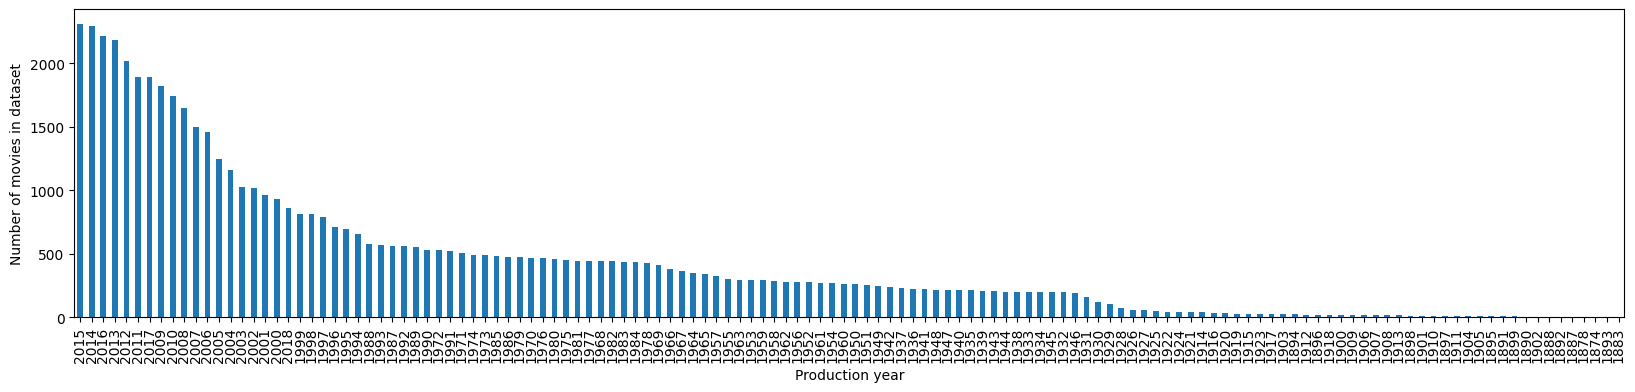

In [82]:
df_movies["production_year"].value_counts().plot(
    kind="bar",
    figsize=(20, 4),
    xlabel="Production year",
    ylabel="Number of movies in dataset",
)


### e) Plot number of ratings as function of movie ID

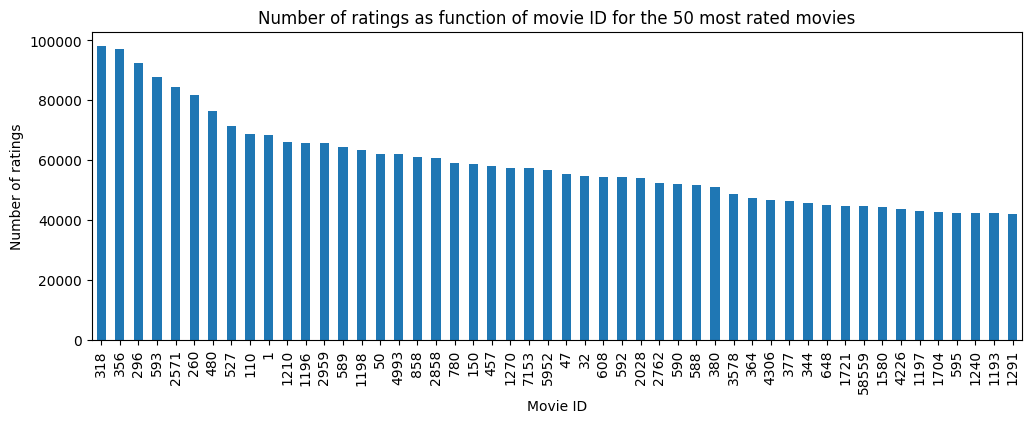

In [83]:
df_ratings["movieId"].value_counts()[:50].plot(
    kind="bar",
    figsize=(12, 4),
    xlabel="Movie ID",
    ylabel="Number of ratings",
    title="Number of ratings as function of movie ID for the 50 most rated movies",
);

### f) Plot average ratings for the 10 most rated movies

In [84]:
# create list of titles and average ratings for the 10 most rated movies
most_rated_movies_title = []
most_rated_movies_mean_rating = []

for Id in most_rated_movies_Id:
    title = df_movies.loc[df_movies['movieId'] == Id, 'title'].values[0]
    most_rated_movies_title.append(title)

    mean_rating = df_ratings.loc[df_ratings['movieId'] == Id, 'rating'].mean()
    most_rated_movies_mean_rating.append(mean_rating)

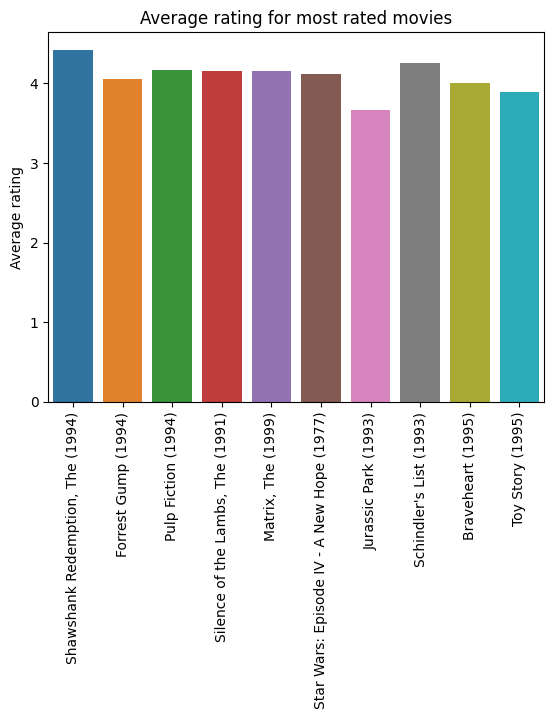

In [85]:
# plot
ax = sns.barplot(x=most_rated_movies_title, y=most_rated_movies_mean_rating)
ax.set(ylabel = 'Average rating', title = 'Average rating for most rated movies')
ax.set_xticklabels(most_rated_movies_title, rotation=90);

### g) Which users have rated the most movies?

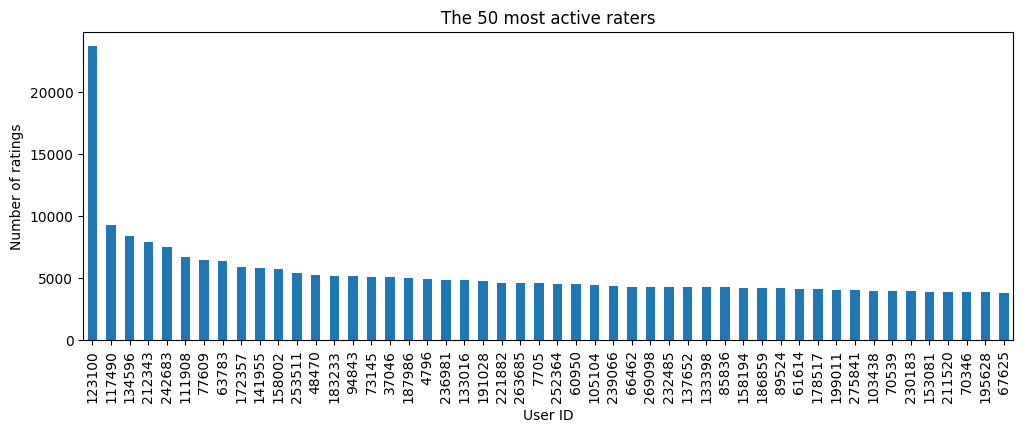

In [86]:
df_ratings['userId'].value_counts()[:50].plot(
    kind="bar",
    figsize=(12, 4),
    xlabel="User ID",
    ylabel="Number of ratings",
    title="The 50 most active raters",
);


### h) What are the most common genre in the dataset?

In [87]:
df_movies['genres'].value_counts().head()

Drama                 8402
Comedy                5372
(no genres listed)    4266
Documentary           4250
Comedy|Drama          2212
Name: genres, dtype: int64

### i) Plot number of ratings as function of average rating for each movie.

In [88]:
df_ratings_per_Id = df_ratings['movieId'].value_counts()
df_ratings_per_Id.head()

318     97999
356     97040
296     92406
593     87899
2571    84545
Name: movieId, dtype: int64

In [89]:
df_mean_per_Id = df_ratings.groupby(['movieId']).mean()
df_mean_per_Id = df_mean_per_Id['rating']
df_mean_per_Id.head()

movieId
1    3.886649
2    3.246583
3    3.173981
4    2.874540
5    3.077291
Name: rating, dtype: float64

In [90]:
df_joined = pd.concat([df_ratings_per_Id, df_mean_per_Id], axis=1, join='inner')
df_joined.rename(columns= {'movieId':'number of ratings', 'rating':'average rating'}, inplace=True)
df_joined.head()

,number of ratings,average rating
318,97999,4.424188
356,97040,4.056585
296,92406,4.173971
593,87899,4.151412
2571,84545,4.149695


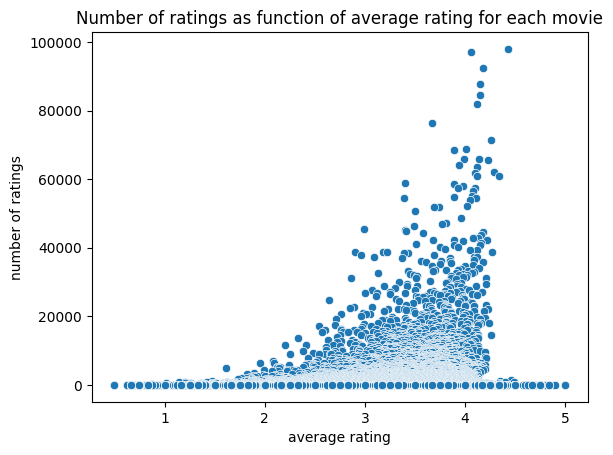

In [91]:
sns.scatterplot(df_joined, x='average rating', y='number of ratings').set_title('Number of ratings as function of average rating for each movie');

---

## 1.2 Sparse matrix

### a) Reducing ratings dataset

#### Step 1: movies with enough ratings

In [92]:
# calculating number of movies with at least 1000 ratings, which is 1% considering mostly rated movies have ~100 000 ratings

number_ratings_per_movie = df_ratings.groupby('movieId').count()
mask = number_ratings_per_movie['rating'] >= 1000
enough_ratings_movies = number_ratings_per_movie[mask].index
enough_ratings_movies

Int64Index([     1,      2,      3,      4,      5,      6,      7,      8,
                 9,     10,
            ...
            175303, 175569, 176101, 176371, 177593, 177615, 177765, 179819,
            180031, 187593],
           dtype='int64', name='movieId', length=3931)

In [93]:
# reduced df containing only movieId with enough ratings
df_ratings_reduced = df_ratings.loc[df_ratings['movieId'].isin(enough_ratings_movies)]
df_ratings_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 24903574 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   year     int64  
dtypes: float64(1), int64(3)
memory usage: 950.0 MB


#### Step 2: movies with good enough average rating

In [94]:
# furhter filtering out movies with good enough rating and saving movieId
df_temp = df_ratings_reduced.groupby(['movieId']).mean()
mask = df_temp['rating'] >= 3.0
best_rated_movies = df_temp[mask].index
best_rated_movies

Int64Index([     1,      2,      3,      5,      6,      7,      8,      9,
                10,     11,
            ...
            175303, 175569, 176101, 176371, 177593, 177615, 177765, 179819,
            180031, 187593],
           dtype='int64', name='movieId', length=3152)

In [95]:
# further reduced df containing only movieId with good enough ratings
df_ratings_reduced = df_ratings_reduced.loc[df_ratings_reduced['movieId'].isin(best_rated_movies)]
df_ratings_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 22049964 entries, 0 to 27753443
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   year     int64  
dtypes: float64(1), int64(3)
memory usage: 841.1 MB


#### Step 3: users who have given enough votes

In [96]:
# filtering out users who have given at least 200 votes
df_temp = df_ratings_reduced.groupby('userId').count()
mask = df_temp['rating'] >= 200
users_with_enough_ratings = df_temp[mask].index
users_with_enough_ratings

Int64Index([     4,     42,     43,     51,     55,     56,     71,     73,
                79,     81,
            ...
            283131, 283148, 283153, 283164, 283165, 283170, 283183, 283184,
            283195, 283224],
           dtype='int64', name='userId', length=29014)

In [97]:
# furhter reducing df_ratings with users who have given enough votes
df_ratings_reduced = df_ratings_reduced.loc[df_ratings_reduced['userId'].isin(users_with_enough_ratings)]
df_ratings_reduced.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 11704593 entries, 42 to 27753282
Data columns (total 4 columns):
 #   Column   Dtype  
---  ------   -----  
 0   userId   int64  
 1   movieId  int64  
 2   rating   float64
 3   year     int64  
dtypes: float64(1), int64(3)
memory usage: 446.5 MB


### b) Create pivot table

In [281]:
# creating a pivot table with NaNs and replcing NaN with 0 by fillna(0)
movies_users_pivot = df_ratings_reduced.pivot(index='movieId', columns='userId', values='rating').fillna(0)
movies_users_pivot.head()

userId,4,42,43,51,55,56,71,73,79,81,...,283131,283148,283153,283164,283165,283170,283183,283184,283195,283224
movieId,,,,,,,,,,,,,,,,,,,,,
1,4.0,4.0,5.0,4.0,5.0,2.5,4.0,4.0,5.0,0.0,...,4.0,0.0,3.0,0.0,2.5,0.0,5.0,4.0,5.0,0.0
2,4.0,3.0,0.0,3.0,0.0,3.5,0.0,0.0,4.0,3.0,...,3.5,0.0,0.0,0.0,0.0,0.0,0.0,2.5,4.0,0.0
3,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,3.5,...,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.0,4.5,4.0
5,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
6,4.5,0.0,0.0,3.0,0.0,4.5,0.0,3.0,0.0,4.0,...,0.0,0.0,0.0,0.0,0.0,4.5,0.0,0.0,4.5,0.0


### c) Create sparse matrix

In [145]:
# creating sparse matrix from the pivot table
movies_users_matrix = csr_matrix(movies_users_pivot)

In [280]:
print(f'The resulting dataset contains {movies_users_matrix.shape[0]} movies rated by {movies_users_matrix.shape[1]} users')

The resulting dataset contains 3152 movies rated by 29014 users


## 1.3 Recommender system

### Create a recommender system

In [102]:
from sklearn.neighbors import NearestNeighbors
from fuzzywuzzy import process       

In [103]:
# define and train model
model_knn = NearestNeighbors(n_neighbors=6, metric='cosine', algorithm='brute')
model_knn.fit(movies_users_matrix)

NearestNeighbors(algorithm='brute', metric='cosine', n_neighbors=6)

In [274]:
movie_name = input('Enter name of movie')

def recommender(movie_name, n_recommendations = 5):
    # identify requested movie (name, index, movieId)
    idx = process.extractOne(movie_name, df_movies['title'])[2]
    id = df_movies.loc[idx]['movieId']
    print(f'Selected movie:  {df_movies["title"][idx]};     Index: {idx};       MovieId: {id}')

    # find corresponding index for requested movie in pivot table
    Id_to_index = pd.DataFrame(movies_users_pivot).reset_index()
    Id_to_index = Id_to_index['movieId']
    idx_pivot = Id_to_index[Id_to_index == id].index[0]

    # make prediction
    distances, indices = model_knn.kneighbors(movies_users_matrix[idx_pivot], n_neighbors = n_recommendations+1)
    print(f'Distances are {distances}')
    print(f'Incides in pivot table are {indices}') 

    # find corresponding movieId from predicted indices (idx_pivot)
    print('Recommended movie Ids are:')
    for idx_pivot in indices:
        id = Id_to_index[idx_pivot]
        print(id)
        # print(df_movies[df_movies['movieId'] == id]['title']) # does not work

recommender(movie_name)

Selected movie:  Rocky (1976);     Index: 1871;       MovieId: 1954
Distances are [[0.         0.34963792 0.35924732 0.3654322  0.36578868 0.37071819]]
Incides in pivot table are [[836 670 531 454 570 854]]
Recommended movie Ids are:
836    1954
670    1387
531    1198
454    1036
570    1240
854    2000
Name: movieId, dtype: int64


In [277]:
# manual print out of recommended movies as printout in recommender does not work
movieId_list = [1954, 1387, 1198, 1036, 1240, 2000]

print(f'Recommended movies for query "Rocky" are:')
for movieId in movieId_list:
    print(df_movies[df_movies['movieId'] == movieId]['title'])

Recommended movies for query "Rocky" are:
1871    Rocky (1976)
Name: title, dtype: object
1356    Jaws (1975)
Name: title, dtype: object
1173    Raiders of the Lost Ark (Indiana Jones and the...
Name: title, dtype: object
1017    Die Hard (1988)
Name: title, dtype: object
1212    Terminator, The (1984)
Name: title, dtype: object
1917    Lethal Weapon (1987)
Name: title, dtype: object


In [278]:
# comment def recommender()
# the following prints only movieId, however in recommender() also idx_pivot is printed. can not understand why.

idx_pivot = 836
print(Id_to_index[idx_pivot])

1954


In [279]:
# comment def recommender()
# not sure how to only print title
# not sure why the following code does not work in recommender()

print(df_movies[df_movies['movieId'] == 1954]['title'])

1871    Rocky (1976)
Name: title, dtype: object


### a) Description of own system
Each movie is a row in the pivot matrix representing a vector of votes. The model looks for 5 vectors which are the closest in spece to the query vector. Calculated is the angle between the vectors (cosine similarity), where smalest angles are found. The vectors are only based on ratings from many users and not on any information about the movie as such (director, genre, year, actors etc)

### b) Description of other systems
The principle is most often comparing vecotrs looking for cosine similarity. What varies is how vectors are premises of comparison. Vectors can for example be build based on information about the movie rather than just user ratings. Here data such as director, genre etc could be used. The algorithm could also learn about the user, meaning take into accout how the specific user has rated movies previously. Choice can be made solely based on the vectors describing the movies. A more refined strategy is to combine information from all users and their preferences leading to either finding other users that have had similar preferences or finding other films which have been rated the same way by other users. [1] <br>

ref [1]. https://www.analyticsvidhya.com/blog/2020/11/create-your-own-movie-movie-recommendation-system/